In [2]:
import os
import sys
sys.path.insert(0,'/home/junwoony/Desktop/DOGSS/')

import numpy as np
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1
%env CUDA_LAUNCH_BLOCKING=1

import mongo
import time
import pickle
import random
import numpy as np
import tqdm
import copy
import matplotlib.pyplot as plt
import multiprocess as mp
import seaborn as sns
import pandas as pd
from pymatgen.io.ase import AseAtomsAdaptor

import torch
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
from torch.optim.lbfgs import LBFGS
from cgcnn.data import StructureData, ListDataset, StructureDataTransformer, collate_pool, MergeDataset
from cgcnn.model import CrystalGraphConvNet

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.metrics import get_scorer
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, LoadInitState #needs skorch 0.4.0, conda-forge version at 0.3.0 doesn't cut it
import skorch.callbacks.base
from skorch.dataset import CVSplit
from skorch.callbacks.lr_scheduler import WarmRestartLR, LRScheduler

from utils.adamwr.adamw import AdamW
from utils.adamwr.cosine_scheduler import CosineLRWithRestarts


from sigopt_sklearn.search import SigOptSearchCV


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1
env: CUDA_LAUNCH_BLOCKING=1


In [5]:
SDT_list = pickle.load(open('../../inputs/surfaces/SDT_list_new.pkl', 'rb'))
docs = pickle.load(open('../../inputs/surfaces/final_docs.pkl', 'rb'))

structures = SDT_list[0]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]



In [6]:
natoms = []
num_elements = []
symbols = []
for doc in docs:
    natoms.append(doc['atoms']['natoms'])
    num_elements.append(len(doc['atoms']['chemical_symbols']))
    symbols.extend(doc['atoms']['chemical_symbols'])
num_symbols = len(set(symbols))
print(num_symbols)

32


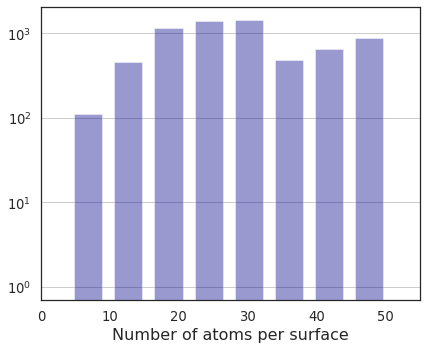

In [7]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(6.8, 5.4)})
sns.set(font_scale = 1.2)
# sns.set_style("whitegrid")
sns.set_style("white")

ax = sns.distplot(np.array(natoms), bins=20, kde=False, color='darkblue'
                 ,hist_kws={"rwidth":0.7})
_ = ax.set_xlim(0, 55)
_ = ax.set_xlabel('Number of atoms per surface', fontsize=16)
# _ = ax.set_title('Surfaces without adsorbates', fontsize=20)
_ = ax.yaxis.grid(True)

plt.yscale('log')
# plt.savefig('./new_backup/natoms.pdf')

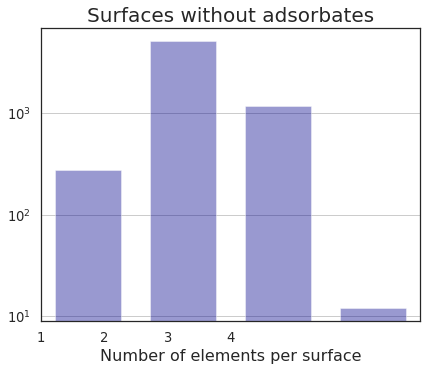

In [8]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(6.8, 5.4)})
sns.set(font_scale = 1.2)
# sns.set_style("whitegrid")
sns.set_style("white")

ax = sns.distplot(np.array(num_elements).astype(int), bins=4, kde=False, color='darkblue'
                 ,hist_kws={"rwidth":0.7})
_ = ax.set_xlim(1, 4)
_ = ax.set_xlabel('Number of elements per surface', fontsize=16)
_ = ax.set_title('Surfaces without adsorbates', fontsize=20)
_ = ax.yaxis.grid(True)
# _ = ax.set_xticks(range(4))
_ = ax.set_xticklabels(['1', '2','3','4'], ha='center')
# _ = ax.set_xticklabels([])
# plt.xticks([1,2,3,4])

plt.yscale('log')
# plt.savefig('./new_backup/nsymbols.pdf')

In [25]:
target_list = np.array([sdt[-1][sdt[-2]].numpy() for sdt in SDT_list]).reshape(-1,1) #get final_pos of free atoms ONLY

In [28]:
target_list[0][0].shape

(9, 3)

In [21]:
SDT_training, SDT_test, target_training, target_test, docs_training, docs_test \
= train_test_split(SDT_list, target_list, docs, test_size=0.1, random_state=42)

In [11]:
cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda")
else:
    device='cpu'

#Make a checkpoint to save parameters every time there is a new best for validation lost
cp = Checkpoint(monitor='valid_loss_best',fn_prefix='./new_backup/valid_best_')

#Callback to load the checkpoint with the best validation loss at the end of training

class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('./new_backup/valid_best_params.pt')
        
load_best_valid_loss = train_end_load_best_valid_loss()
print('device:', device)

device: cuda


In [22]:
def get_distance(atom_pos, nbr_fea_idx, nbr_fea_offset, cells):
    nbr_pos = atom_pos[nbr_fea_idx]
    differ = nbr_pos - atom_pos.unsqueeze(1) + torch.bmm(nbr_fea_offset, cells)
    differ_sum = torch.sum(differ**2, dim=2)
    distance = torch.sqrt(differ_sum).unsqueeze(-1)            
    return distance
differences = []
c = 0
max_num_nbr = 12

for sdt in SDT_list:
    nbr_fea_idx = sdt[2]
    nbr_fea_offset = sdt[3]
    atom_pos =sdt[4]
    cells = sdt[7]
    atom_pos_final = sdt[-1]
    free_atom_idx = sdt[-2]
#     bond_distance = get_distance(atom_pos, nbr_fea_idx, nbr_fea_offset, cells)[free_atom_idx]
#     final_distance = get_distance(atom_pos_final, nbr_fea_idx, nbr_fea_offset, cells)[free_atom_idx]
#     c += len(atom_pos[free_atom_idx])*12
    bond_distance = get_distance(atom_pos, nbr_fea_idx, nbr_fea_offset, cells)
    final_distance = get_distance(atom_pos_final, nbr_fea_idx, nbr_fea_offset, cells)
    N, M, C = bond_distance.shape
    bond_distance = bond_distance #* fake_nbr.float().expand(N, M, C)    
    final_distance = final_distance #* fake_nbr.float().expand(N, M, C) 
    
    c += len(atom_pos) * max_num_nbr
    differences.append((final_distance - bond_distance).view(-1))
differences = torch.cat(differences)**2
# differences = torch.clamp(differences, min=1e-8)
assert c == len(differences)
# dist_err = torch.mean(torch.abs(differences))
# torch.log(dist_err)
# dist_err = torch.mean(torch.sqrt(differences))
dist_err = torch.mean(torch.abs(differences))
dist_err


tensor(0.0059)

In [32]:
def diff(sdt, target):
    free_atom_idx = sdt[-2]
    diff = np.sum(((target[0] - sdt[4].numpy()[free_atom_idx]))**2.,axis=1)**0.5 
    return diff

np.mean(np.abs(np.concatenate([diff(sdt, target) for sdt,target in zip(SDT_test, target_test)])))

0.13144483

In [33]:
def diff_position(sdt, target):
    free_atom_idx = sdt[-2]
    diff = (target[0] - sdt[4].numpy()[free_atom_idx])
    return diff

differences = []
for sdt, target in zip(SDT_test, target_test):
    differences.append(diff_position(sdt, target))
    
differences = np.concatenate(differences)
np.mean(np.abs(differences))

0.059913088

In [10]:
from torch.optim import lr_scheduler
import torch.optim as optim


train_test_splitter = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

batchsize = 17
# warm restart scheduling from https://arxiv.org/pdf/1711.05101.pdf
# LR_schedule = LRScheduler(CosineLRWithRestarts, batch_size=batchsize, epoch_size=len(SDT_training), restart_period=10, t_mult=1.2)

#### For Sigopt
LR_schedule = LRScheduler("MultiStepLR", milestones=[100], gamma=0.1)

#############
# To extract intermediate features, set the forward takes only the first return value to calculate loss
class MyNet(NeuralNetRegressor):
    def get_loss(self, y_pred, y_true, **kwargs):
        y_pred = y_pred[0] if isinstance(y_pred, tuple) else y_pred  # discard the 2nd output
        differ=torch.sum((y_pred-y_true.cuda())**2.0,dim=1)
        if torch.nonzero(differ).shape[0] != differ.shape[0]:
            print('zero sqrt for Loss')
#             zero_idx = (differ == 0).nonzero()
#             differ[zero_idx] = 1e-6
        differ = torch.clamp(differ, min=1e-8)

        return torch.mean(torch.sqrt(differ))


net = MyNet(
    CrystalGraphConvNet,
    module__orig_atom_fea_len = orig_atom_fea_len,
    module__nbr_fea_len = nbr_fea_len,
    batch_size=batchsize, #214
    module__classification=False,
    lr=0.0393415,
    max_epochs= 200,
    module__energy_mode="Harmonic", #["Harmonic", "Morse", "LJ"], Default = "Harmonic"
    module__atom_fea_len=236, #46,
    module__h_fea_len=6,
    module__h_fea_len_dist=4,
    module__h_fea_len_const=4,
#     module__h_fea_len_D=(3,256),
    module__n_conv=12, #8
    module__n_h_dist=0,
    optimizer__weight_decay=0.0000454,
    module__n_h_const=0,
#     module__n_h_D=(1,12),
#     module__max_num_nbr=12, #9
#     module__opt_step_size=(0.1,0.7), #0.3
    module__min_opt_steps=30,
    module__max_opt_steps=150,
    module__momentum=0.8,
    optimizer=AdamW,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__shuffle=True,
    iterator_train__collate_fn = collate_pool,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn = collate_pool,
    device=device,
#     criterion=torch.nn.MSELoss,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    train_split = CVSplit(cv=train_test_splitter),
    callbacks=[cp,LR_schedule , load_best_valid_loss],

)


net.initialize()
net.load_params(f_history = './new_backup/valid_best_history.json',
               f_optimizer = './new_backup/valid_best_optimizer.pt',
               f_params = './new_backup/valid_best_params.pt')

In [11]:
torch.cuda.empty_cache()

In [12]:
natoms =[]
types = []
steps = []
distances = []
filtered_idx = []
docs_test_new = []
SDT_test_new, target_test_new= [], []
print(len(docs_test), len(SDT_test), len(target_test))
for i, doc in enumerate(docs_test):
    sdt = SDT_test[i]
    target = target_test[i]

    atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
    atoms_final = mongo.make_atoms_from_doc(doc, is_initial=False)
    if atoms.constraints:
        fixed_atom_idx = atoms.constraints[0].index
        base = np.ones(len(atoms.positions))
        base[fixed_atom_idx] = 0
        free_atom_idx = np.where(base==1)[0]
        
    else:
        free_atom_idx = np.arange(len(atoms))
    difference = atoms.positions[free_atom_idx] - atoms_final.positions[free_atom_idx]
    dist = np.sqrt(np.sum(difference**2, axis=1))
    
    if np.mean(dist) > 0.06:
        distances.append(dist)
        filtered_idx.append(doc['idx'])
        
        SDT_test_new.append(sdt)
        docs_test_new.append(doc)
        target_test_new.append(target)

docs_test = docs_test_new
SDT_test = SDT_test_new
target_test = target_test_new
print(len(docs_test), len(SDT_test), len(target_test))


659 659 659
601 601 601


In [13]:
SDT_train, SDT_valid, target_train, target_valid = train_test_split(SDT_training, target_training, 
                                                                    test_size=0.1, random_state=42)
def get_targets(dummy_SDT, dummy_targets):
    targets = []
    for i, target in enumerate(dummy_targets):
        free_atom_idx = dummy_SDT[i][-2]
        targets.append(target[0].reshape(-1,3))
        assert len(free_atom_idx) == len(target[0])
    return np.concatenate(targets)

def get_distance(pred, true):
    diff = np.sum((pred - true)**2, axis=1)
    return np.sqrt(diff)

def get_initial(dummy_SDT):
    init_test = []
    for sdt in dummy_SDT:
        free_atom_idx = sdt[-2]
        atom_pos = sdt[4][free_atom_idx]
        init_test.append(atom_pos)
    return np.concatenate(init_test)
        

In [67]:
# init_test = get_initial(SDT_test)
# pred_test = net.predict(SDT_test)
# true_test = get_targets(SDT_test, target_test)

init_test = pickle.load(open('./new_backup/init_test.pkl', 'rb'))
pred_test = pickle.load(open('./new_backup/pred_test.pkl', 'rb'))
true_test = pickle.load(open('./new_backup/true_test.pkl', 'rb'))
pred_test2 = pickle.load(open('./new_backup2/pred_test.pkl', 'rb'))
pred_test3 = pickle.load(open('./new_backup3/pred_test.pkl', 'rb'))

pred_test = (pred_test2 + pred_test3)/2 

torch.cuda.empty_cache()

distance_test = get_distance(pred_test, true_test)
distance_pred_initial = get_distance(pred_test, init_test)
distance_init = get_distance(init_test, true_test)

distance_test2 = get_distance(pred_test2, true_test)
distance_test3 = get_distance(pred_test3, true_test)

distance_test = np.mean(np.array([distance_test, distance_test2, distance_test3]), axis=0)
distance_test_std = np.std(np.array([distance_test, distance_test2, distance_test3]), axis=0)

###### Per ATOM MAE ##### (NOT per structure MAE)

MAE_pred_final = np.mean(distance_test)
MAE_pred_initial = np.mean(distance_pred_initial)
MAE_initial_final = np.mean(distance_init)

In [68]:
print(np.mean(distance_test), np.mean(distance_test_std))

0.06182582 0.009809099


In [69]:
#### RMSD ####
RMSD_init = np.sqrt(np.mean(np.sum((init_test - true_test)**2, axis=1)))
RMSD_pred = np.sqrt(np.mean(np.sum((pred_test - true_test)**2, axis=1)))
print(RMSD_init, RMSD_pred, RMSD_pred/RMSD_init)

0.17722969 0.08731102 0.49264333


In [70]:
print(MAE_pred_final, MAE_pred_initial, MAE_initial_final)
print(MAE_pred_final/MAE_initial_final, 1 - MAE_pred_final/MAE_initial_final)

0.06182582 0.11745748 0.1383077
0.44701645 0.5529835522174835


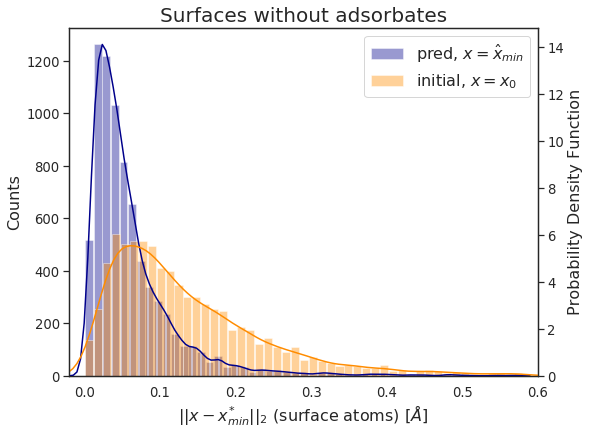

In [76]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(8.4, 6.4)})
sns.set(font_scale = 1.2)
# sns.set_style("whitegrid")
sns.set_style("white")

idx = np.where(distance_test < 0.6)[0]
idx_init = np.where(distance_init < 0.6)[0]

print()

ax = sns.distplot(distance_test[idx], bins=50, kde=False, color='darkblue', label='pred, $x = \hat{x}_{min}$'
                 ,hist_kws={"rwidth":0.9})
ax = sns.distplot(distance_init[idx_init], bins=50, kde=False, color='darkorange', label='initial, $x = x_{0}$'
                 ,hist_kws={"rwidth":0.9})

_ = ax.set_xlim(-0.02, 0.6)
_ = ax.set_xlabel('$\||x - x^{*}_{min}\||_{2}$ (surface atoms) [$\AA$]', fontsize=16)
_ = ax.set_ylabel('Counts', fontsize=16)
_ = ax.set_title('Surfaces without adsorbates', fontsize=20)
_ = ax.legend(loc='upper right', fontsize=16)
# _ = ax.yaxis.grid(True)

ax2 = ax.twinx()
ax2 = sns.kdeplot(distance_test[idx], color='darkblue')
ax2 = sns.kdeplot(distance_init[idx_init], color='darkorange')
_ = ax2.set_ylabel('Probability Density Function', fontsize=16)

# plt.xscale('log')
plt.savefig('./new_backup/plot.pdf')

In [115]:
def analysis(SDT, docs, distance, distance_pred_initial, distance_init):
    dist_per_surface = []
    init_dist_per_surface = []
    dist_pred_init_per_surface = []
    dist_init_per_surface = []
    
    total_atoms = 0
    for i in range(len(SDT)):
        doc = docs[i]
        sdt = SDT[i]
        
        num_atoms = sdt[-2].shape[0]
        
        dist_per_surface.append(np.mean(distance[total_atoms: total_atoms+num_atoms]))
        init_dist = torch.sqrt(torch.sum(((sdt[4] - sdt[-1])[sdt[-2]])**2, dim=1))
        init_dist_per_surface.append(torch.mean(init_dist))
        dist_pred_init_per_surface.append(np.mean(distance_pred_initial[total_atoms: total_atoms+num_atoms]))
        dist_init_per_surface.append(np.mean(distance_init[total_atoms: total_atoms+num_atoms]))
        
        total_atoms += num_atoms
    
    assert len(distance) == total_atoms
    assert len(distance_pred_initial) == total_atoms

    results =[]
    reduced = []
    best = []
    bad_result =[]
    good_result=[]
    bad_docs = []
    good_docs = []
    test_idx = 0
    MAE, MAE_pos, MAE_pred_init, MAE_init, MAE_init2 = [], [], [], [], []
    
    ###### Per Structure MAE ##### (NOT Per Atom MAE)

    for dist, doc, init_dist, pred_init_dist, dist_init in zip(dist_per_surface, docs, init_dist_per_surface, 
                                                    dist_pred_init_per_surface, dist_init_per_surface):
        if doc['idx'] in filtered_idx:
        
            atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
            atoms_final = mongo.make_atoms_from_doc(doc, is_initial=False)
            base = np.zeros_like(atoms.positions)
            base[atoms.constraints[0].get_indices()] = 1
            free_atom_idx = np.where(base == 0)[0]

            total_steps = len(doc['distances_per_step'])
            reduced_steps = len(np.where(doc['distances_per_step'] >= dist)[0])
            results.append([total_steps, reduced_steps, reduced_steps/total_steps])
            reduced.append(reduced_steps/total_steps)
            
        ###### Per Structure MAE ##### (NOT Per Atom MAE)
            MAE_ratio = dist/init_dist.item()
            MAE.append(dist)
            MAE_pred_init.append(pred_init_dist)
            MAE_init.append(init_dist)
            MAE_init2.append(dist_init)
            MAE_pos.append(np.mean(np.abs((atoms.positions - atoms_final.positions)[free_atom_idx])))
            if reduced_steps/total_steps < 0.1:
                bad_docs.append(doc)
                bad_result.append([test_idx, total_steps, reduced_steps, np.round(reduced_steps/total_steps, 4), 
                                   np.round(init_dist.item(),4), np.round(dist,4), np.round(MAE_ratio,4)])
            else:
                good_docs.append(doc)
                good_result.append([test_idx, total_steps, reduced_steps, np.round(reduced_steps/total_steps, 4), 
                                   np.round(init_dist.item(),4), np.round(dist,4), np.round(MAE_ratio,4)])
            test_idx += 1
    return reduced, np.mean(MAE), np.mean(MAE_pred_init), np.mean(MAE_init), np.mean(MAE_init2), MAE_pos, bad_result, good_result, bad_docs, good_docs

In [116]:
def get_initial(SDT_list):
    init_test = []
    for sdt in SDT_list:
        free_atom_idx = sdt[-2]
        atom_pos = sdt[4][free_atom_idx]
        init_test.append(atom_pos)
    return np.concatenate(init_test)

In [117]:
###### Per Structure MAE ##### (NOT Per Atom MAE)
reduced, MAE_per_str, MAE_pred_init_per_str, MAE_init_final_per_str, MAE_init2, \
MAE_pos, bad_result, good_result, bad_docs, good_docs \
= analysis(SDT_test, docs_test, distance_test, distance_pred_initial, distance_init)

In [118]:
print(MAE_per_str, MAE_pred_init_per_str, MAE_init_final_per_str, MAE_init2)
print(MAE_per_str/MAE_init_final_per_str, 1 - MAE_per_str/MAE_init_final_per_str)

0.063097425 0.117505774 0.13785177 0.13785176
0.45771936 0.5422806441783905


In [119]:
np.mean(reduced) #after filtering dist > 0.06 on test set

0.32937513409170305

In [113]:
natoms =[]
types = []
steps = []
distances = []
filtered_idx = []
docs_test_new = []
for i, doc in enumerate(docs_test):
    std = SDT_test[i]
    target = target_test[i]

    atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
    atoms_final = mongo.make_atoms_from_doc(doc, is_initial=False)
    if atoms.constraints:
        fixed_atom_idx = atoms.constraints[0].index
        base = np.ones(len(atoms.positions))
        base[fixed_atom_idx] = 0
        free_atom_idx = np.where(base==1)[0]
        
    else:
        free_atom_idx = np.arange(len(atoms))
    difference = atoms.positions[free_atom_idx] - atoms_final.positions[free_atom_idx]
    dist = np.sqrt(np.sum(difference**2, axis=1))
    RMSD = np.sqrt(np.mean(np.sum(difference**2, axis=1)))
    if np.mean(dist) > 0.06:
        distances.append(dist)
        filtered_idx.append(doc['idx'])
print(RMSD)

0.11008012753940598


(array([15., 21., 16., 14., 23., 22., 19., 24., 27., 33., 36., 18., 16.,
        23., 19., 19., 16., 13., 23., 16., 13., 16., 14.,  9., 14., 14.,
         4.,  8., 11.,  9.,  5.,  8.,  3.,  8.,  1.,  9.,  3.,  3.,  3.,
         7.,  0.,  7.,  6.,  3.,  4.,  2.,  1.,  2.,  0.,  1.]),
 array([0.06068707, 0.06546743, 0.07024778, 0.07502814, 0.07980849,
        0.08458885, 0.0893692 , 0.09414956, 0.09892991, 0.10371027,
        0.10849062, 0.11327098, 0.11805133, 0.12283169, 0.12761204,
        0.1323924 , 0.13717275, 0.1419531 , 0.14673346, 0.15151381,
        0.15629417, 0.16107452, 0.16585488, 0.17063523, 0.17541559,
        0.18019594, 0.1849763 , 0.18975665, 0.19453701, 0.19931736,
        0.20409772, 0.20887807, 0.21365843, 0.21843878, 0.22321914,
        0.22799949, 0.23277985, 0.2375602 , 0.24234056, 0.24712091,
        0.25190127, 0.25668162, 0.26146198, 0.26624233, 0.27102269,
        0.27580304, 0.2805834 , 0.28536375, 0.29014411, 0.29492446,
        0.29970482]),
 <a list of 50

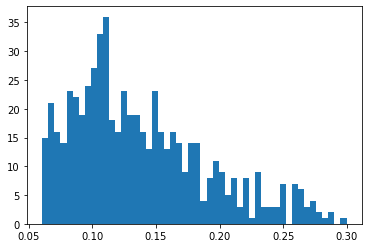

In [114]:
d_mean=[]
for dist in distances:
    d_mean.append(np.mean(dist))
plt.hist(d_mean, bins=50)

In [ ]:
final_scaled_positions = []
pred_scaled_positions =[]
initial_scaled_positions = []

total_atoms = 0
for i in tqdm.tqdm(range(len(docs_test))):
    idx = i
    doc = docs_test[idx]
    sdt = SDT_test[idx]
    fixed_base = sdt[-3]
    fixed_atom_idx = np.where(fixed_base == 1)[0]
    free_atom_idx2 = np.where(fixed_base == 0)[0]
    free_atom_idx = sdt[-2]
    assert free_atom_idx2.all() == free_atom_idx.numpy().all()
    num_atoms = len(free_atom_idx)

    init = init_test[total_atoms:total_atoms+num_atoms]
    pred = pred_test[total_atoms:total_atoms+num_atoms]
    true = true_test[total_atoms:total_atoms+num_atoms]
    loss = np.mean(distance_test[total_atoms: total_atoms+num_atoms])
    total_atoms += num_atoms

    if doc['idx'] in filtered_idx:
        if doc['data'] == 'surface':
            atoms_init = mongo.make_atoms_from_doc(doc, is_initial=True)

            atoms_final = mongo.make_atoms_from_doc(doc, is_initial=False)
            atoms_pred = copy.deepcopy(atoms_final)
            atoms_pred.positions[free_atom_idx] = pred

        elif doc['data'] == 'slab':
            atoms_init = mongo.make_atoms_from_doc(doc, is_initial=True)
            atoms_final = mongo.make_atoms_from_doc(doc, is_initial=False)
            atoms_pred = copy.deepcopy(atoms_final)
            atoms_pred.positions[free_atom_idx] = pred

        initial_scaled_positions.append(atoms_init.get_scaled_positions()[free_atom_idx])
        final_scaled_positions.append(atoms_final.get_scaled_positions()[free_atom_idx])
        pred_scaled_positions.append(atoms_pred.get_scaled_positions()[free_atom_idx])

final_scaled_positions, pred_scaled_positions, initial_scaled_positions\
=  np.concatenate(final_scaled_positions), np.concatenate(pred_scaled_positions), np.concatenate(initial_scaled_positions)

In [ ]:
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

init = initial_scaled_positions[:,1]
pred = pred_scaled_positions[:,1]
true = final_scaled_positions[:,1]
mae = np.mean(np.abs(pred-true))
mae_init = np.mean(np.abs(init-true))
print(mae, mae_init)

In [89]:
good_idx = np.array(good_result)[:,0].astype(int)
bad_idx = np.array(bad_result)[:,0].astype(int)
# np.random.shuffle(good_idx)

total_atoms = 0
for i in range(len(docs_test)):
    idx = i
    doc = docs_test[idx]
    sdt = SDT_test[idx]
    fixed_base = sdt[-3]
    fixed_atom_idx = np.where(fixed_base == 1)[0]
    free_atom_idx2 = np.where(fixed_base == 0)[0]
    free_atom_idx = sdt[-2]
    assert free_atom_idx2.all() == free_atom_idx.numpy().all()
    num_atoms = len(free_atom_idx)

    init = init_test[total_atoms:total_atoms+num_atoms]
    pred = pred_test[total_atoms:total_atoms+num_atoms]
    true = true_test[total_atoms:total_atoms+num_atoms]
    loss = np.mean(distance_test[total_atoms: total_atoms+num_atoms])
    total_atoms += num_atoms

    if doc['idx'] in filtered_idx:
        if doc['data'] == 'surface':
            atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
            atoms.write('./new_backup/traj_surface/initial/%d_%.4f_initial.traj' %(doc['idx'], loss))

            atoms_pred = copy.deepcopy(atoms)
            atoms_pred.positions[free_atom_idx] = pred
            atoms_pred.write('./new_backup/traj_surface/test/%d_%.4f_pred.traj' %(doc['idx'],loss))

        elif doc['data'] == 'slab':
            atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
            atoms.write('./new_backup/traj_slab/initial/%d_%.4f_initial.traj' %(doc['idx'], loss))

            atoms_pred = copy.deepcopy(atoms)
            atoms_pred.positions[free_atom_idx] = pred
            atoms_pred.write('./new_backup/traj_slab/test/%d_%.4f_pred.traj' %(doc['idx'],loss))